In [1]:
import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings
from obspy.core.event import Catalog
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [2]:
def PygmtBegin(figmap, region):
    pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
                FONT_LABEL = '8',
                MAP_LABEL_OFFSET = '4p',
                MAP_TICK_LENGTH_PRIMARY = '5p',
    #             PS_MEDIA ='A4',
                PROJ_LENGTH_UNIT = 'c',
                MAP_ANNOT_OFFSET_PRIMARY = '5p',
                MAP_ANNOT_OFFSET_SECONDARY = '5p',
                MAP_FRAME_TYPE = 'fancy',
                MAP_FRAME_WIDTH = 'auto',
                FORMAT_GEO_MAP = 'D',
                PS_CHAR_ENCODING = 'Standard+',
                MAP_FRAME_PEN = '2p,black')
#     grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
    
def Plot_event(figmap, Event):
    figmap.shift_origin(xshift = '10c', yshift = '9c')
    lat = 42; lon = 44
    colfill = '217.6/217.6/217.6'
    figmap.coast(region='g', 
              projection = f'E{lon}/{lat}/180/8c', 
              resolution = 'c', 
              land = colfill, 
              shorelines ='1/0.1p,' + colfill, 
              C = colfill, 
              frame = True)

    figmap.plot(x = lon, y = lat, style ='s0.6c', pen ='0.2', color = 'red')

    distlims = [60,90,120,150]
    for dists in distlims:
        figmap.plot(x = lon, y = lat, style ='E-' + str(2 * dists) + 'd', 
                 pen ='1p,black,3_1:0p',t = '60')

    figmap.text(x = 44, y = -20,  text = f'60@.', font='9p')
    figmap.text(x = 44, y = -48,  text = '90@.', font='9p')
    figmap.text(x = 44, y = -79,  text = '120@.', font='9p')
    figmap.text(x = -137, y = -71,   text = '150@.', font='9p')

    figmap.plot(x=Event['Lon'],y=Event['Lat'],
                sizes = np.exp(Event['Mag']/100)*0.52,
                color=Event['Dep'],cmap = 'cmapEQs.cpt' , style="a",pen="1p,black",transparency=40)

    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '15p,Times-Roman',
                      MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                      MAP_LABEL_OFFSET = '0.8c', 
                      MAP_TICK_LENGTH_PRIMARY = '0.2c',
                      MAP_FRAME_PEN = '1.5p'):    
        figmap.colorbar(cmap = 'cmapEQs.cpt', position = 'x9.5/0.55+w7c/0.4c+ml', frame = ['a100f50','+L"Depth (km)"'])    

In [15]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/02_Station_result_csv/2010-2020_Mw6_120-150degree_SKKS'

phase = 'SKKS'
Mag = 6
DATApath = f'/Volumes/home/Research/STEP/01_Split/DATA_{phase}_Mw6_ZRT'
evt_cata1 = 'Event_catalog_2010-2015_mw6.xml'
evt_cata2 = 'Event_catalog_2015-2020_mw6.xml'
CATA = read_events(f'{DATApath}/{evt_cata1}')
CATA += read_events(f'{DATApath}/{evt_cata2}')
notplotLIST = ['TRLG','BRNG','GUDG']

SAVEpath = '/Volumes/home/Research/STEP/04_Station_result_map/2010-2020_Mw6_SKKS'

filemag = 'Mw6_SKKS'

In [16]:
def Event_clean():
    Ori_Event = {'Time':[],
            'Lat':[],
            'Lon':[],
            'Mag':[],
            'Dep':[] }
    for evt in CATA:
        yyyy = str(evt.origins[0].time.year).zfill(4)
        mm   = str(evt.origins[0].time.month).zfill(2)
        dd   = str(evt.origins[0].time.day).zfill(2)
        hh   = str(evt.origins[0].time.hour ).zfill(2)
        mi   = str(evt.origins[0].time.minute).zfill(2)
        ss   = str(evt.origins[0].time.second).zfill(2)
        TIME = f'{yyyy}{mm}{dd}_{hh}{mi}{ss}'
        lat = evt.origins[0].latitude; lon = evt.origins[0].longitude
        mag = evt.magnitudes[0].mag
        dep = evt.origins[0].depth/1000
        Ori_Event['Time'].append(TIME)
        Ori_Event['Lat'].append(lat)
        Ori_Event['Lon'].append(lon)
        Ori_Event['Mag'].append(mag)
        Ori_Event['Dep'].append(dep)
    return Ori_Event

# Station distribution and all Catalog event 

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/1) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 224 degrees.


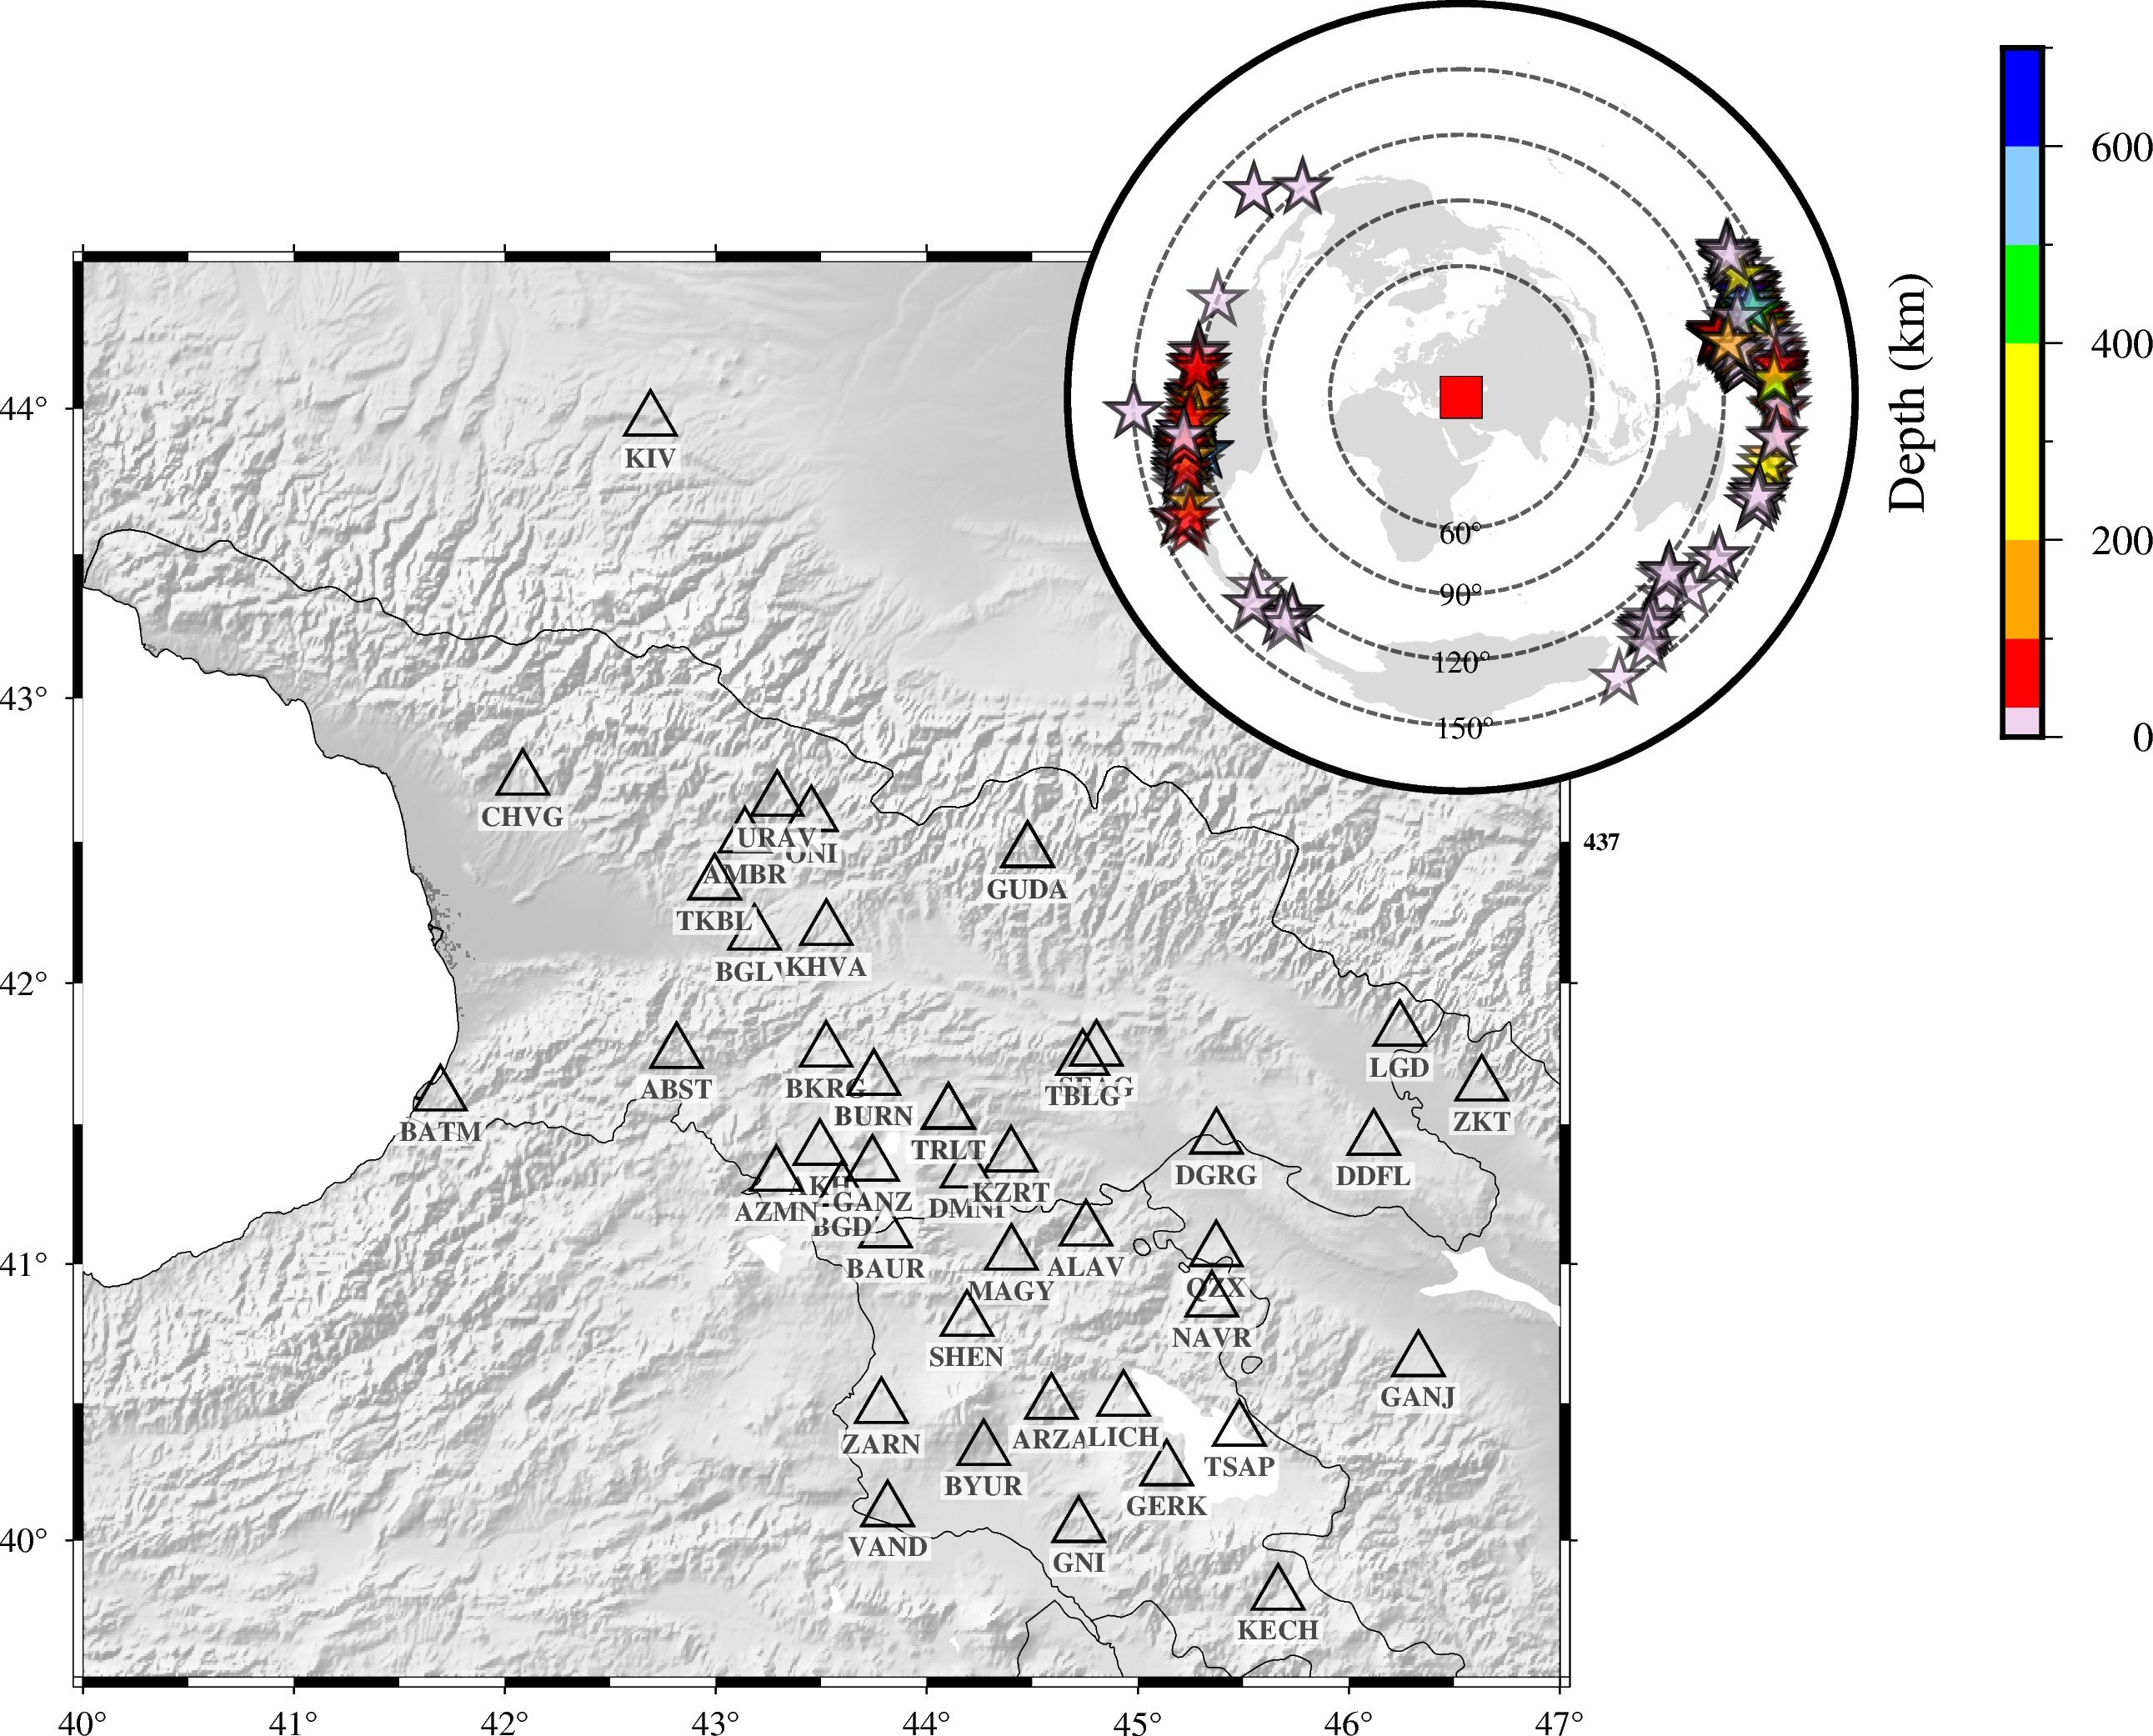

In [19]:
Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

TextLon = []; TextLat=[]; Text=[]
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    TextLon.append(st_lon)
    TextLat.append(st_lat-0.17)
    Text.append(STA)
    df = pd.read_csv(CSVpath)
    df_select = df[df['Pick'] == True][df['Quality']!= 'Poor']
    figmap.plot(x=st_lon,y=st_lat,style='t0.6c',pen='0.8p,black')
    figmap.text(x=st_lon,y=st_lat-0.13,text=STA, font="8p,Times-Bold,black",fill='white',transparency=30)


Event = pd.DataFrame(Ori_Event)
num_evt = len(Event)
figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)
##============= plot earthquake distribution 
Plot_event(figmap, Event)
   
figmap.savefig(f'{SAVEpath}/00_Plot_Stationdistri_{filemag}.png')
figmap.savefig(f'{SAVEpath}/00_Plot_Stationdistri_{filemag}.pdf')
figmap.show()

# SKS number I used 

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/1) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 224 degrees.


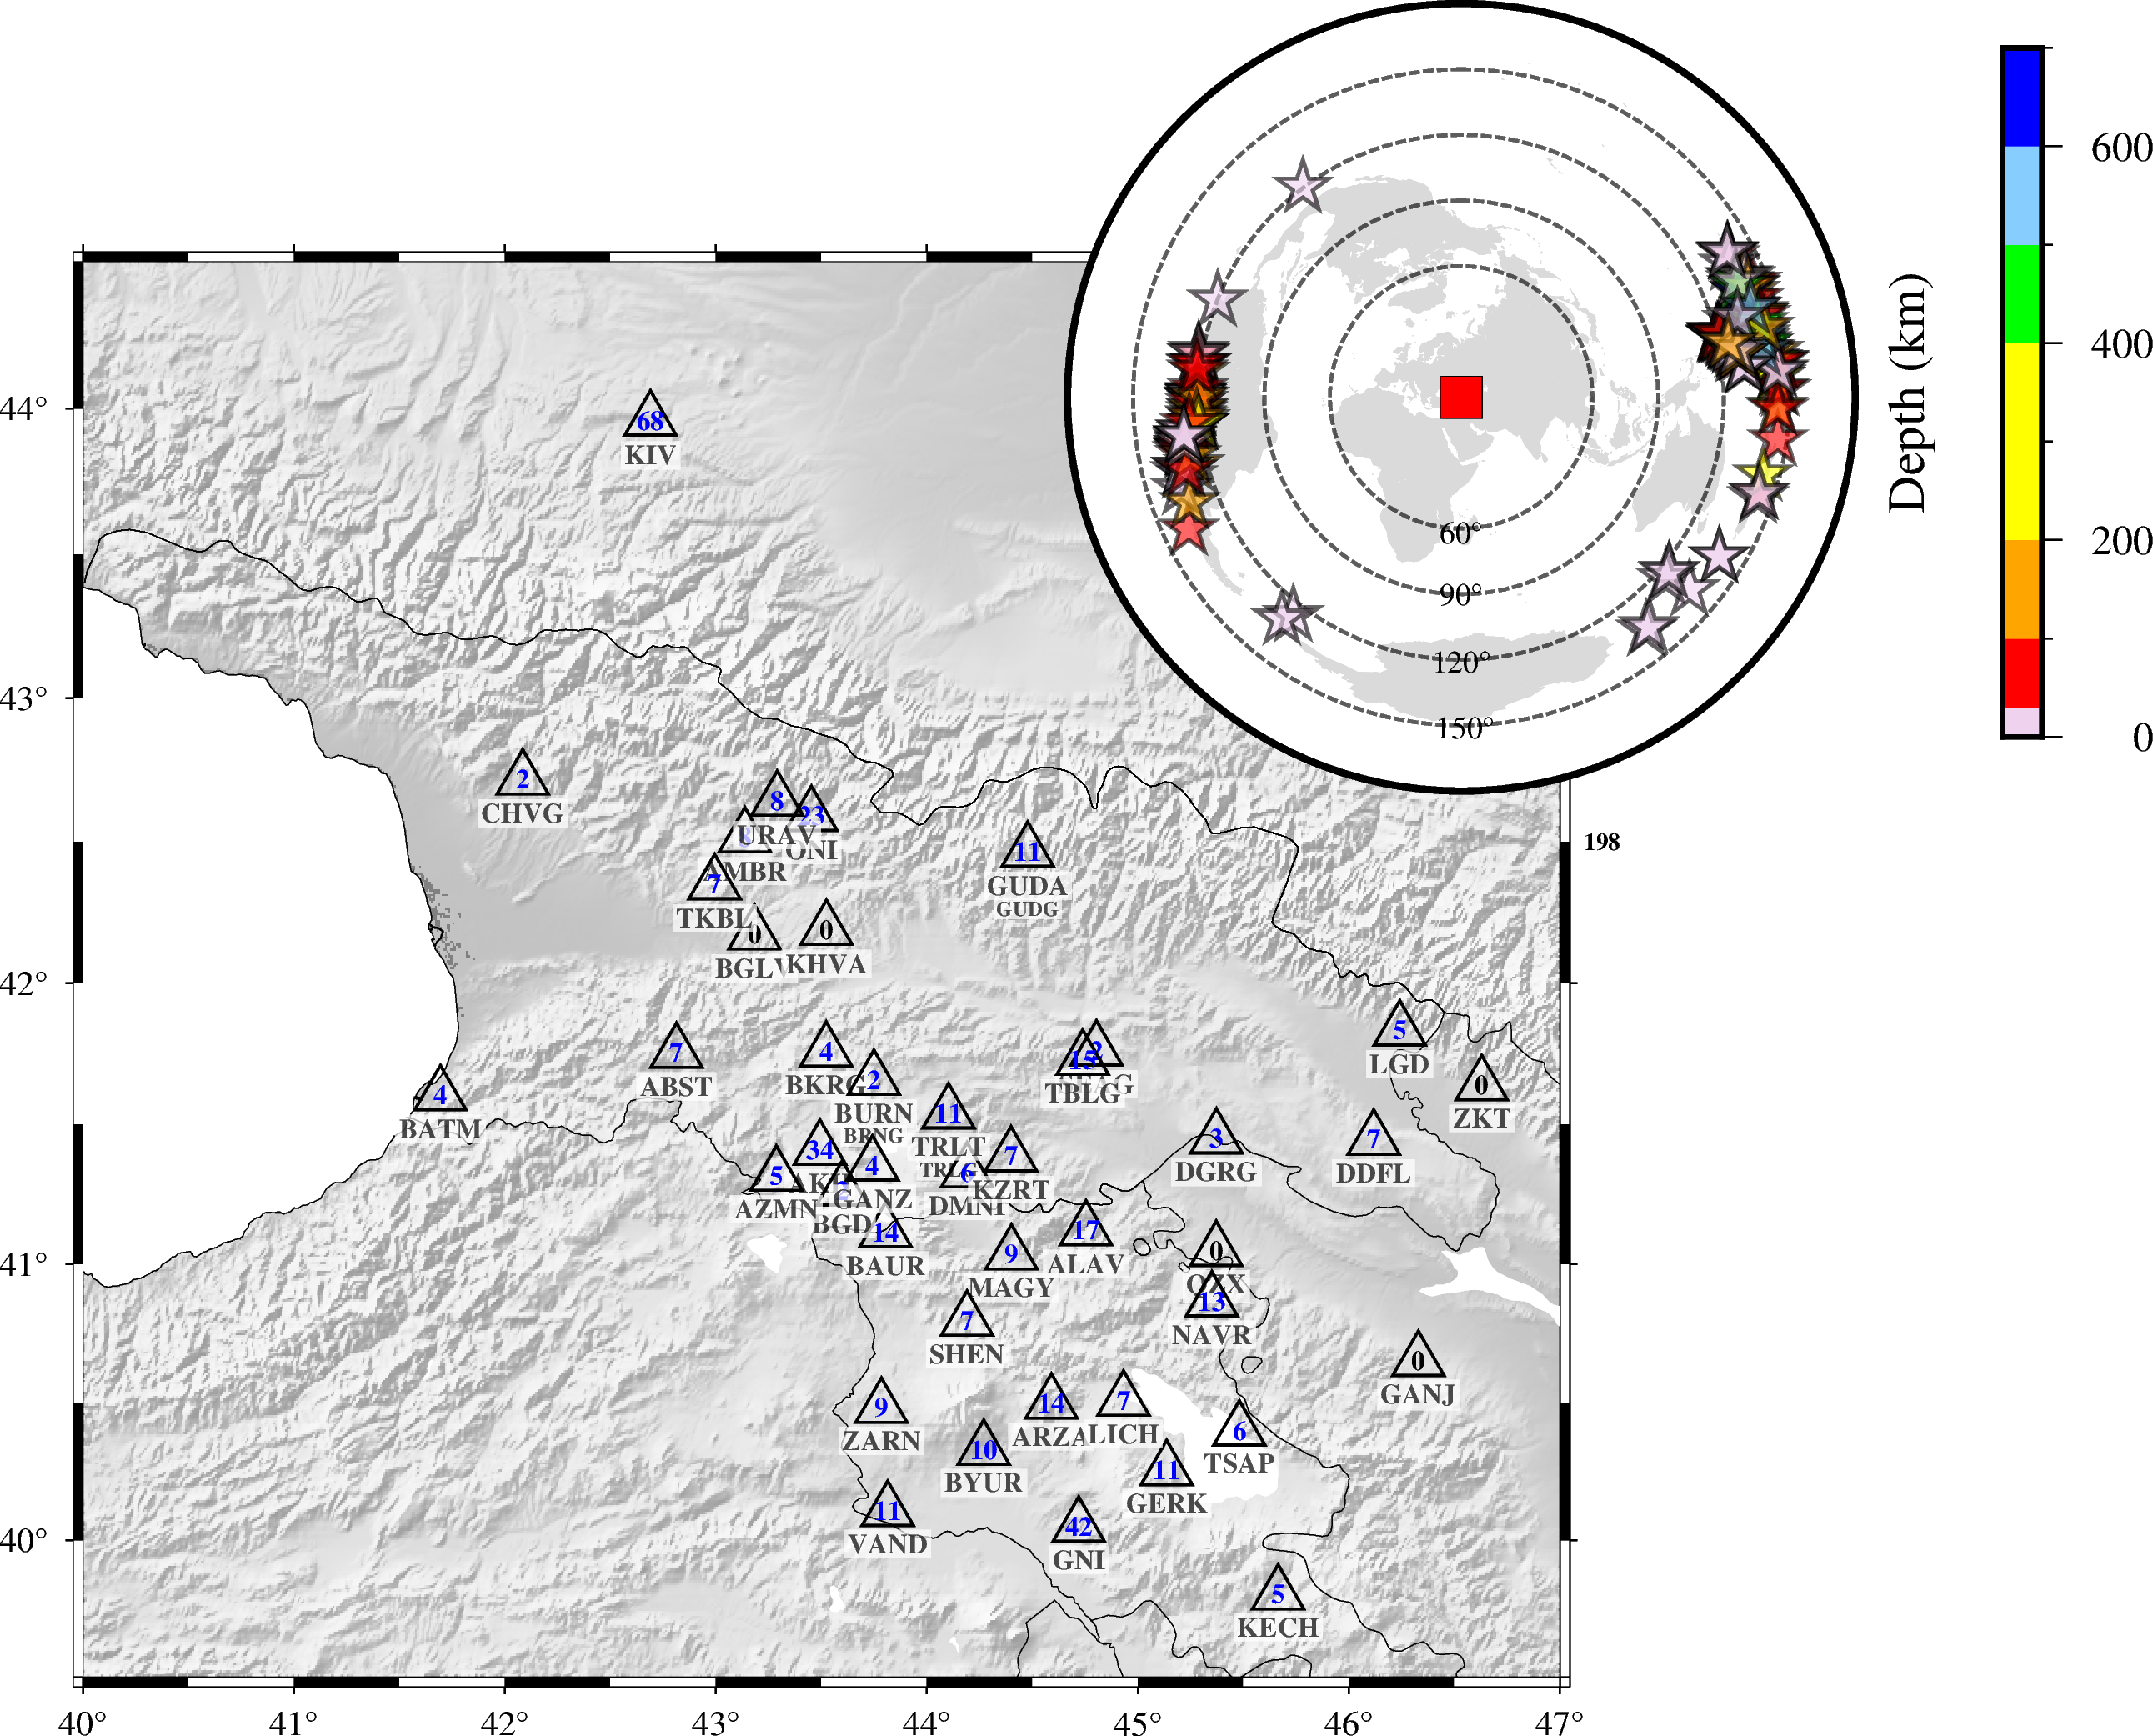

In [20]:
Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent = []
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):

    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] 
    STA = netsta.rsplit('.')[1]
    
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    df = pd.read_csv(CSVpath)
    df = df[df['Phase']==phase][df['SNRQ']>=5]
    
    
    if STA == 'GUDA': 
        secondSTA = 'GUDG'
        secdf = pd.read_csv(glob.glob(f'{Path}/*{secondSTA}*.csv')[0])
        secdf = secdf[secdf['Phase']==phase]#[secdf['Mag']>=7.0]
        STAdatalength = len(df) + len(secdf)
    elif STA == 'BURN':
        secondSTA = 'BRNG'
        secdf = pd.read_csv(glob.glob(f'{Path}/*{secondSTA}*.csv')[0])
        secdf = secdf[secdf['Phase']==phase]#[secdf['Mag']>=7.0]
        STAdatalength = len(df) + len(secdf)
    elif STA == 'TRLT':
        secondSTA = 'TRLG'
        secdf = pd.read_csv(glob.glob(f'{Path}/*{secondSTA}*.csv')[0])
        secdf = secdf[secdf['Phase']==phase]#[secdf['Mag']>=7.0]
        STAdatalength = len(df) + len(secdf)
    else:
        STAdatalength = len(df)
    
    st_lat = values['latitude']; st_lon = values['longitude']
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=30)
        figmap.plot(x=st_lon,y=st_lat,style='t0.6c',pen='0.8p,black')
        if STAdatalength != 0:
            figmap.text(x=st_lon,y=st_lat,text=STAdatalength, font="8p,Times-Bold,blue")
        else: 
            figmap.text(x=st_lon,y=st_lat,text=STAdatalength, font="8p,Times-Bold,black")
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=30)
    
    for event in glob.glob(f'{DATApath}/*{STA}/*'):
        evtTime = event.rsplit('/')[-1]
        if evtTime not in USEevent:   
            USEevent.append(evtTime)

##============= clean up catalog I used 
Event = Ori_Event.copy()
removelist = [x for x in Event['Time'] if x not in USEevent]
for reevent in removelist:
    index = Event['Time'].index(reevent)
    for keys in Event:
        Event[keys].pop(index)
NEWEvent=pd.DataFrame(Event)    
num_evt = len(NEWEvent)
figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)
##============= plot earthquake distribution                
Plot_event(figmap, NEWEvent)   
figmap.savefig(f'{SAVEpath}/01_Plot_SKSnumber_{filemag}.png')
figmap.savefig(f'{SAVEpath}/01_Plot_SKSnumber_{filemag}.pdf')
figmap.show()

## Number of picking 

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/1) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 224 degrees.


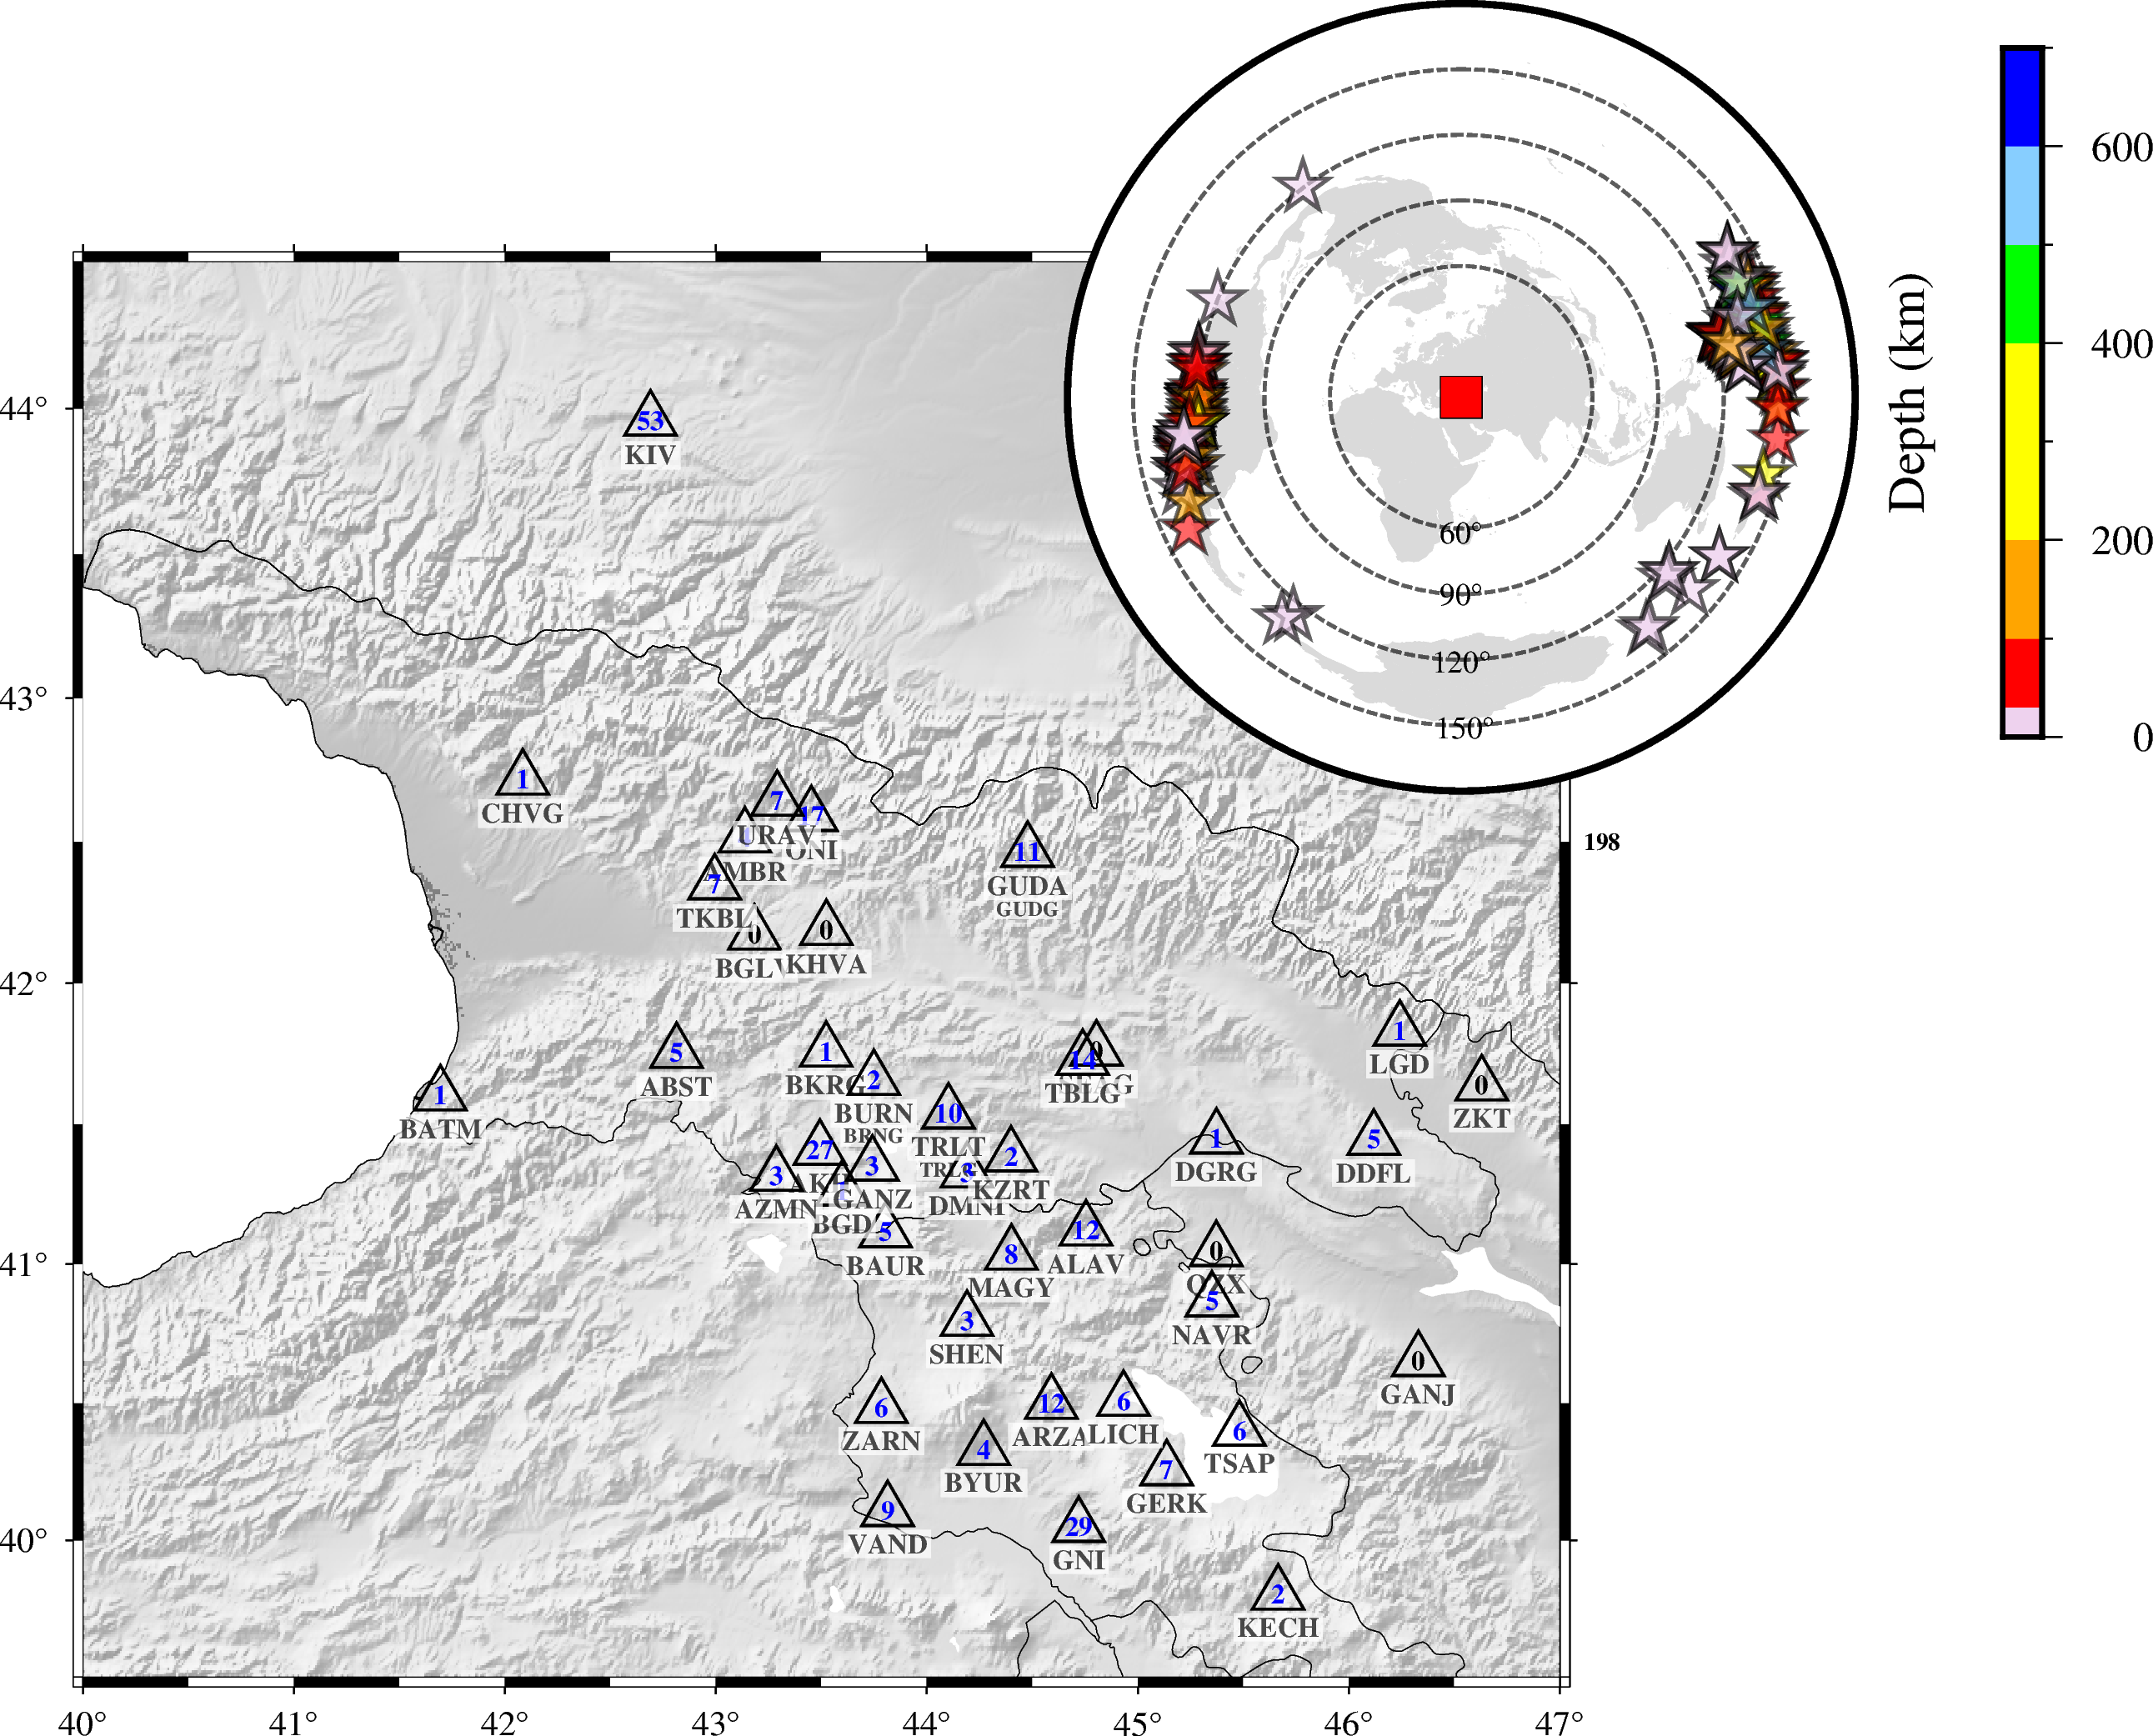

In [21]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')
Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent = []
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):

    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] 
    STA = netsta.rsplit('.')[1]
    
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    df = pd.read_csv(CSVpath)
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]
    
    
    if STA == 'GUDA': 
        secondSTA = 'GUDG'
        secdf = pd.read_csv(glob.glob(f'{Path}/*{secondSTA}*.csv')[0])
        secdf = secdf[secdf['Phase']==phase]#[secdf['Mag']>=7.0]
        STAdatalength = len(df) + len(secdf)
    elif STA == 'BURN':
        secondSTA = 'BRNG'
        secdf = pd.read_csv(glob.glob(f'{Path}/*{secondSTA}*.csv')[0])
        secdf = secdf[secdf['Phase']==phase]#[secdf['Mag']>=7.0]
        STAdatalength = len(df) + len(secdf)
    elif STA == 'TRLT':
        secondSTA = 'TRLG'
        secdf = pd.read_csv(glob.glob(f'{Path}/*{secondSTA}*.csv')[0])
        secdf = secdf[secdf['Phase']==phase]#[secdf['Mag']>=7.0]
        STAdatalength = len(df) + len(secdf)
    else:
        STAdatalength = len(df)
    
    st_lat = values['latitude']; st_lon = values['longitude']
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=30)
        figmap.plot(x=st_lon,y=st_lat,style='t0.6c',pen='0.8p,black')
        if STAdatalength != 0:
            figmap.text(x=st_lon,y=st_lat,text=STAdatalength, font="8p,Times-Bold,blue")
        else:
            figmap.text(x=st_lon,y=st_lat,text=STAdatalength, font="8p,Times-Bold,black")
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=30)
    
    for event in glob.glob(f'{DATApath}/*{STA}/*'):
        evtTime = event.rsplit('/')[-1]
        if evtTime not in USEevent:   
            USEevent.append(evtTime)

##============= clean up catalog I used 
Event = Ori_Event.copy()
removelist = [x for x in Event['Time'] if x not in USEevent]
for reevent in removelist:
    index = Event['Time'].index(reevent)
    for keys in Event:
        Event[keys].pop(index)
NEWEvent=pd.DataFrame(Event)    
num_evt = len(NEWEvent)
figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)
##============= plot earthquake distribution                
Plot_event(figmap, NEWEvent)   
figmap.savefig(f'{SAVEpath}/02_Plot_SKSnumber_{filemag}_pick.png')
figmap.savefig(f'{SAVEpath}/02_Plot_SKSnumber_{filemag}_pick.pdf')
figmap.show()